# Predict Future Sales

This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition is aimed to work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

The objective is to predict total sales for every product and store in the next month. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# 1. Import data

In [2]:
# The given five files include the infomation of items(name, item_id, category_id), 
# shop(shop_name, shop_id), item_categories(item_category_name, item_category_id) 
# sales_train(date, date_block_num, shop_id, item_id, item_price, item count_day) and
# test(id, shop_id, item_id)
items  = pd.read_csv('input/items.csv')
train = pd.read_csv('input/sales_train.csv')
test = pd.read_csv('input/test.csv')
item_category = pd.read_csv('input/item_categories.csv')
shops = pd.read_csv('input/shops.csv')

## 1.1 Review items data

In [3]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [4]:
# There are 22170 items in total.
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [5]:
# The number of items dramatically varies for different categories. Some categroies contains more items than others. 
items["item_category_id"].value_counts()

40    5035
55    2365
37    1780
31    1125
58     790
30     756
72     666
19     628
61     598
23     501
43     471
57     427
56     397
67     394
63     366
76     333
41     332
69     317
38     310
62     295
59     294
64     290
78     278
75     277
28     240
70     228
77     220
45     195
66     178
20     175
      ... 
4       15
83      15
42      12
9       12
46      12
8        9
82       8
34       8
27       8
74       8
17       7
81       7
39       7
71       6
36       6
32       6
80       6
18       6
13       6
48       5
0        4
35       4
52       3
53       3
26       3
50       2
1        2
51       1
10       1
79       1
Name: item_category_id, Length: 84, dtype: int64

## 1.2 Review item categories data

In [6]:
item_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
# There are 84 categories in total.
item_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


## 1.3 Review shops data

In [8]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
# There are 60 shops in total.
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


## 1.4 Review train data

In [10]:
# The postive number in item_cnt_day column stands for the nubmer of sales during the day
# while negative number stands for return.
# The date_block_num stands for the month number: 0 stands for Jan 2013, 1 stands for Feb 2013
# and so on and so forth. The range of the month number is between 0 - 33, which means the spreadsheet
# contrains sales data from Jan 2013 to Oct 2015.
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


### 1.4.1 Create new train dataset

Since the train table doesn't include the item_name, category and category_id,
we need to combine few tables together.

In [12]:
new_train = pd.merge(train, items, how = 'left', on = 'item_id')
new_train = pd.merge(new_train, item_category, how = 'left', on = 'item_category_id')
new_train = pd.merge(new_train, shops, how = 'left', on = 'shop_id')

In [13]:
new_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


Then we can separate year, month and day from date column. In addition, we can add day of the week, if it is a holiday to the table.

In [14]:
df_temp = new_train.date.str.split(".",n=2,expand=True)
df_temp.columns = ['Day','Month','Year']
new_train = pd.concat([new_train, df_temp], axis=1)
new_train['New_date'] = pd.to_datetime(new_train[['Year','Month','Day']].apply(lambda x: '-'.join(x), axis=1))
new_train['Day_of_week'] = new_train['New_date'].dt.dayofweek

In [15]:
col = new_train.columns.tolist()[-2:-1] \
    + new_train.columns.tolist()[-3:-2] \
    + new_train.columns.tolist()[-4:-3] \
    + new_train.columns.tolist()[-5:-4] \
    + new_train.columns.tolist()[-1:] \
    + new_train.columns.tolist()[1:-5] 
new_train = new_train[col]

Let's see how holiday affect the sales.

In [16]:
# !pip install workalendar
from workalendar.europe import Russia
cal = Russia()
new_train['Is_holiday'] = new_train['New_date'].apply(lambda x: cal.is_holiday(x))
new_train

,New_date,Year,Month,Day,Day_of_week,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,Is_holiday
0,2013-01-02,2013,01,02,2,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",False
1,2013-01-03,2013,01,03,3,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False
2,2013-01-05,2013,01,05,5,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False
3,2013-01-06,2013,01,06,6,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False
4,2013-01-15,2013,01,15,1,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",False
5,2013-01-10,2013,01,10,3,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,"Москва ТРК ""Атриум""",False
6,2013-01-02,2013,01,02,2,0,25,2565,549.00,1.0,DEEP PURPLE Stormbringer (фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",False
7,2013-01-04,2013,01,04,4,0,25,2572,239.00,1.0,DEFTONES Koi No Yokan,55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",False
8,2013-01-11,2013,01,11,4,0,25,2572,299.00,1.0,DEFTONES Koi No Yokan,55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",False
9,2013-01-03,2013,01,03,3,0,25,2573,299.00,3.0,DEL REY LANA Born To Die,55,Музыка - CD локального производства,"Москва ТРК ""Атриум""",False


In [17]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 15 columns):
New_date              datetime64[ns]
Year                  object
Month                 object
Day                   object
Day_of_week           int64
date_block_num        int64
shop_id               int64
item_id               int64
item_price            float64
item_cnt_day          float64
item_name             object
item_category_id      int64
item_category_name    object
shop_name             object
Is_holiday            bool
dtypes: bool(1), datetime64[ns](1), float64(2), int64(5), object(6)
memory usage: 338.8+ MB


In [18]:
# the data varies from week to week
new_train['date_block_num'].value_counts()

11    143246
23    130786
2     121347
0     115690
1     108613
7     104772
6     100548
5     100403
12     99349
10     96736
8      96137
9      94202
3      94109
14     92733
4      91759
13     89830
24     88522
19     86614
22     86428
17     82408
21     79361
18     78760
16     78529
15     77906
20     73157
25     71808
26     69977
31     57029
27     56274
30     55549
29     54617
28     54548
33     53514
32     50588
Name: date_block_num, dtype: int64

In [19]:
# the data varies from shop to shop
new_train['shop_id'].value_counts()

31    235636
25    186104
54    143480
28    142234
57    117428
42    109253
27    105366
6      82663
58     71441
56     69573
46     66321
50     65173
19     63911
15     59511
35     58445
21     58133
7      58076
47     56695
26     53910
18     53227
24     53032
53     52921
16     52734
30     50860
29     49225
38     46013
22     45434
51     44433
52     43502
59     42108
41     41967
37     39638
44     39530
43     39282
4      38242
5      38179
14     36979
45     35891
55     34769
12     34694
2      25991
3      25532
17     22950
48     21612
10     21397
13     17824
49     15849
39     13440
0       9857
32      7947
23      6963
34      5752
1       5678
33      5027
40      4257
9       3751
8       3412
20      1792
11       499
36       306
Name: shop_id, dtype: int64

In [20]:
# The data varies from item to item. We got 22170 items in item tabel, 
# however, we have 21807 items from train tabel, which means some items
# were never sold or the record were missing.
new_train['item_id'].value_counts()

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
7856      6602
3732      6475
2308      6320
4870      5811
3734      5805
1855      5681
5821      5389
16787     5283
6675      5122
7894      5107
2445      5056
1830      4976
5823      4974
6497      4904
5272      4853
13071     4804
6740      4675
3183      4615
4178      4527
2416      4487
7893      4380
6466      4324
6498      4278
6503      4274
6457      4269
         ...  
181          1
2647         1
599          1
21074        1
20670        1
601          1
14942        1
4278         1
596          1
595          1
19010        1
594          1
16255        1
7731         1
588          1
2636         1
184          1
21060        1
18290        1
4684         1
590          1
21061        1
183          1
15913        1
3628         1
593          1
13866        1
16574        1
20668        1
0            1
Name: item_id, Length: 21807, dtype: int64

In [21]:
# Generally, the sales of a specific item were less than 5 per shop per day. 
# However, we also see some wholesale examples as well. The occurrences of wholesale 
# were rare.
new_train['item_cnt_day'].value_counts()

 1.0      2629372
 2.0       194201
 3.0        47350
 4.0        19685
 5.0        10474
-1.0         7252
 6.0         6338
 7.0         4057
 8.0         2903
 9.0         2177
 10.0        1820
 11.0        1263
 12.0        1083
 13.0         918
 14.0         716
 15.0         638
 16.0         544
 17.0         438
 18.0         391
 20.0         364
 19.0         347
 21.0         290
 22.0         242
 24.0         204
 23.0         198
 25.0         180
 26.0         176
 30.0         147
 28.0         131
 27.0         130
           ...   
 95.0           1
 96.0           1
 102.0          1
 105.0          1
 109.0          1
 112.0          1
 113.0          1
 118.0          1
 128.0          1
 129.0          1
 131.0          1
 132.0          1
 135.0          1
 146.0          1
 200.0          1
 147.0          1
 149.0          1
 153.0          1
 154.0          1
 156.0          1
 157.0          1
 504.0          1
 163.0          1
 164.0          1
 167.0    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117196d30>,
      dtype=object)

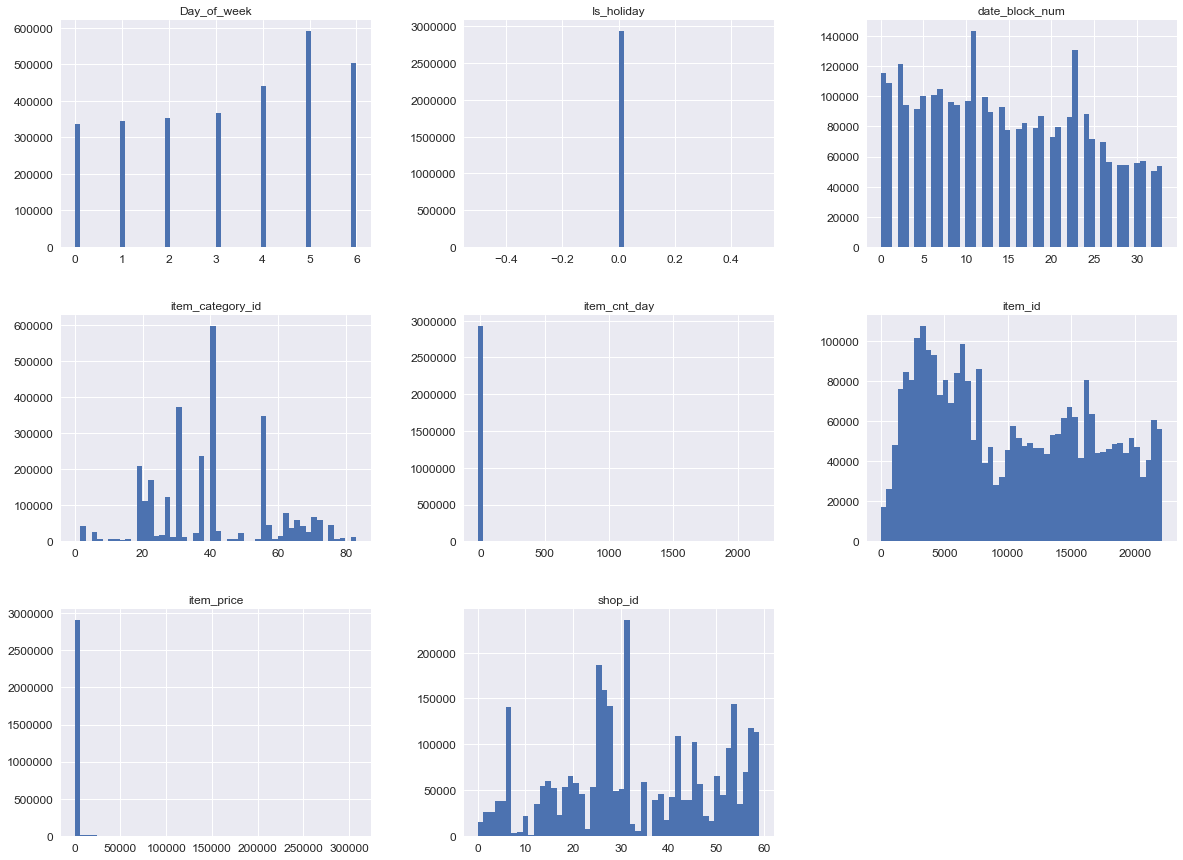

In [22]:
new_train.hist(bins=50, figsize=(20,15))

# 1.5 Review test data

In [23]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [24]:
# we have 5100 records for each shop
test['shop_id'].value_counts()

59    5100
16    5100
28    5100
26    5100
25    5100
24    5100
22    5100
21    5100
19    5100
18    5100
15    5100
58    5100
14    5100
12    5100
10    5100
7     5100
6     5100
5     5100
4     5100
3     5100
31    5100
34    5100
35    5100
36    5100
57    5100
56    5100
55    5100
53    5100
52    5100
50    5100
49    5100
48    5100
47    5100
46    5100
45    5100
44    5100
42    5100
41    5100
39    5100
38    5100
37    5100
2     5100
Name: shop_id, dtype: int64

In [25]:
# we have 42 records for each item
test['item_id'].value_counts()

2047     42
19744    42
15406    42
13359    42
3240     42
1193     42
7338     42
11436    42
9389     42
21795    42
13231    42
13743    42
3624     42
1577     42
7722     42
5675     42
11948    42
16046    42
19488    42
15278    42
10029    42
4395     42
18464    42
2088     42
6186     42
8237     42
20643    42
8365     42
12463    42
12591    42
         ..
1492     42
11985    42
8528     42
16083    42
3797     42
7895     42
18140    42
20189    42
10064    42
16211    42
7255     42
13394    42
11345    42
13266    42
20830    42
8656     42
14803    42
6615     42
20958    42
12882    42
14931    42
4694     42
6743     42
16988    42
19037    42
21086    42
21214    42
17244    42
21342    42
2049     42
Name: item_id, Length: 5100, dtype: int64

# 2. Exploratory data analysis

## 2.1 Seasonal price change analysis

The price of a specific item may change owing to different month. I shall find patterns for items.

In [26]:
new_train.head()

,New_date,Year,Month,Day,Day_of_week,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,Is_holiday
0,2013-01-02,2013,01,02,2,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",False
1,2013-01-03,2013,01,03,3,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False
2,2013-01-05,2013,01,05,5,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False
3,2013-01-06,2013,01,06,6,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",False
4,2013-01-15,2013,01,15,1,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",False


In [44]:
# create a sub dataframe 
df_work = new_train[['Year','Month','item_id','item_cnt_day']]

In [46]:
df_work

,Year,Month,item_id,item_cnt_day
0,2013,01,22154,1.0
1,2013,01,2552,1.0
2,2013,01,2552,-1.0
3,2013,01,2554,1.0
4,2013,01,2555,1.0
5,2013,01,2564,1.0
6,2013,01,2565,1.0
7,2013,01,2572,1.0
8,2013,01,2572,1.0
9,2013,01,2573,3.0


In [110]:
grouped = df_work.groupby(['Year','Month','item_id']).agg(np.sum)

In [115]:
grouped_reset = grouped.add_suffix('_Sum').reset_index()

In [119]:
a = grouped_reset[grouped_reset['item_id'] == 1993]

In [122]:
a

,Year,Month,item_id,item_cnt_day_Sum
33346,2013,05,1993,6.0
41690,2013,06,1993,1.0
50140,2013,07,1993,4.0
58523,2013,08,1993,2.0
66568,2013,09,1993,1.0
74445,2013,10,1993,4.0
82504,2013,11,1993,1.0
113682,2014,03,1993,1.0
127571,2014,05,1993,1.0
134241,2014,06,1993,3.0


# 3. Feature selection

# 4. Model implementation 

# 5. Model tuning

# 6. Testing